## Oppgave 1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Stiller inn ønsket parameter for figurer
fontsize = 12
newparams = {'axes.titlesize': fontsize, 'axes.labelsize': fontsize,
             'lines.linewidth': 1.5, 'lines.markersize': 12,
             'figure.figsize': (10, 4), 'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 'legend.fontsize': fontsize,
            'legend.handlelength': 1.5, 'figure.autolayout': True}

hBar = 1.0545718e-34 # Planck const
m = 9.10938e-31 # mass of electron
e = 1.60217733e-19 # Coulomb, elementary charge
V0 = -1.2e-16# Potential energy
w = 65e-12 # 65 picometers, width of well
b = 10e-12 # 10 picometers, distance between atoms in molecule/crystall

In [2]:
'''
Denne funksjonen tar inn oppgavenummer, og antall elementer i bølgefunksjonen,
og returnerer Energiegenverdiene, og de normaliserte bølgefunksjonene, x-verdiene, og lengden på x-aksen
'''
def eigenvalue_eigenvector(exercise, N_w = 10, N = 1000):
    if exercise == 1:
        x, DeltaX, L, d, e = exer_1(N)
    elif exercise == 2:
        x, DeltaX, L, d, e = exer_2(N)
    elif exercise == 3:
        x, DeltaX, L, d, e = exer_3(N)
    elif exercise == 4:
        x, DeltaX, L, d, e = exer_4(N, N_w)
    # Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
    E, psi = eigh_tridiagonal(d, e)
    # Normerer psi
    normalize_vectors(N, psi, DeltaX)
    sign_correction(N, psi)
    return E, psi, x, L

In [3]:
def exer_1(N):
    L = 50e-12 # 50 picometers
    DeltaX = L/(N+1) # Delta x
    x = np.linspace(0, L, N+2)
    c = -hBar**2/(2*m * DeltaX**2)
    d = -2*c * np.ones(N) # the diagonal elements of the array
    e = c * np.ones(N-1) # the off-diagonal elements of the array
    return x[1:-1], DeltaX, L, d, e

In [4]:
# Denne funksjonen normerer bølgefunksjonen slik at integralet fra 0 til L av |psi(x)|^2 blir 1
def normalize_vectors(N, psi, DeltaX):
    for i in range(N):
        psi[:,i] = psi[:,i] / np.sqrt(DeltaX * np.sum(psi[:,i]**2))

In [5]:
# Denne funksjonen sørger for at psi alltid starter med positivt stigningstall
def sign_correction(N, psi):
    for i in range(N):
        if psi[0,i] < 0:
            psi[:,i] = -1 * psi[:,i]
        elif psi[0,i] == 0:
            idx = 1
            value = 0
            while value == 0:
                value = psi[idx,i]
                if value < 0:
                    psi[:,i] = -1 * psi[:,i]
                idx +=1

In [6]:
def analytic(x, L):
    N = x.size
    E_analytic = np.zeros(N)
    psi_analytic = np.zeros((N, N))
    for i in range(N):
        k_i = (i+1) * np.pi/L
        E_analytic[i] = hBar**2 * k_i**2 / (2*m)
        psi_analytic[:,i] = np.sqrt(2/L) * np.sin((i+1)*np.pi * x / L)
    return E_analytic, psi_analytic

In [7]:
def plot1():
    plt.rcParams.update(newparams)
    plt.subplot(1, 2, 1)
    plt.title(r"Numeriske løsninger på $\psi_\mathrm{i}(x)$, i = 1, 2, 3")
    plt.plot(x, psi[:, 0], label="$\psi_1(x)$")
    plt.plot(x, psi[:, 1], label="$\psi_2(x)$")
    plt.plot(x, psi[:, 2], label="$\psi_3(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.xticks([0, L],
              ['0', r'$x = L$'])
    plt.yticks([-np.sqrt(2/L), 0, np.sqrt(2/L)],
              [r'$-\sqrt{2/L}$', r'0', r'$\sqrt{2/L}$'])
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title(r"Analytiske løsninger på $\psi_\mathrm{i}(x)$, i = 1, 2, 3")
    plt.plot(x, psi_a[:, 0], label="$\psi_1(x)$")
    plt.plot(x, psi_a[:, 1], label="$\psi_2(x)$")
    plt.plot(x, psi_a[:, 2], label="$\psi_3(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.xticks([0, L],
              ['0', r'$x = L$'])
    plt.yticks([-np.sqrt(2/L), 0, np.sqrt(2/L)],
              [r'$-\sqrt{2/L}$', r'0', r'$\sqrt{2/L}$'])
    plt.legend(loc='best')
    
    plt.show()

In [8]:
def plot2():
    width = 10
    height = 4
    plt.figure(figsize=(width, height))
    n = 1 + np.arange(10)
    plt.title("Plott av beregnede og analytiske energinivåer")
    plt.plot(n, E_a[:n.size], 'r.', label='Analytisk')
    plt.plot(n, E[:n.size], 'b+', label='Numerisk')
    plt.legend(loc='best')
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.xlabel('Kvantetall n')
    plt.ylabel(r'Energiegenverdi $E_\mathrm{n}$ [ J ]')
    plt.show()

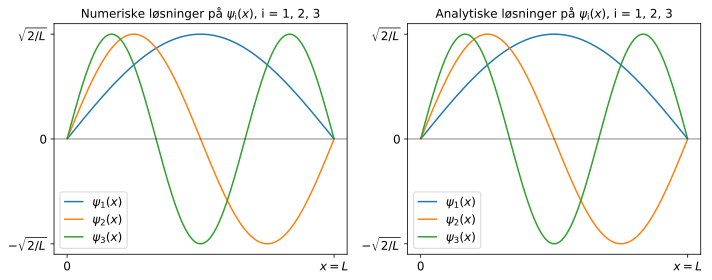

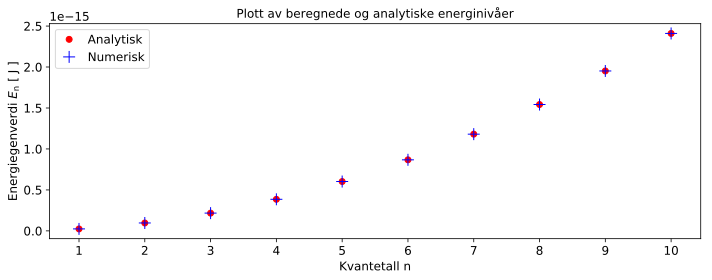

In [9]:
E, psi, x, L = eigenvalue_eigenvector(1) # Numerical solutions

E_a, psi_a = analytic(x, L) # Analytic solutions

plot1()
plot2()

In [10]:
def orthonormal_check():
    N = x.size
    ort_mat = np.zeros((N, N))
    DeltaX = L/(N+1)
    for i in range(N):
        ort_mat[i,i] = DeltaX*np.sum(psi[:,i]*psi[:,i])
        for j in range(i+1, N):
            elem = DeltaX*np.sum(psi[:,i]*psi[:,j])
            ort_mat[i,j], ort_mat[j,i] = elem, elem
    np.set_printoptions(precision=3)
    print("Sjekker at egenfunksjonene er ortonormale:\n", ort_mat, '\n')

def complete_set_check():
    N = x.size
    com_mat = np.zeros((N, N))
    DeltaX = L/(N+1)
    for i in range(N):
        com_mat[i,i] = DeltaX*np.sum(psi[i,:]*psi[i,:])
        for j in range(i+1, N):
            elem = DeltaX*np.sum(psi[i,:]*psi[j,:])
            com_mat[i,j], com_mat[j,i] = elem, elem
    np.set_printoptions(precision=3)
    print("Sjekker at egenfunksjonene danner et fullstendig sett:\n", com_mat, '\n')

orthonormal_check()
complete_set_check()

Sjekker at egenfunksjonene er ortonormale:
 [[ 1.000e+00 -1.805e-15 -1.512e-15 ... -9.908e-18  1.562e-17 -1.524e-17]
 [-1.805e-15  1.000e+00  1.512e-15 ... -1.524e-18  4.573e-18  2.248e-17]
 [-1.512e-15  1.512e-15  1.000e+00 ...  1.372e-17 -1.067e-17 -2.820e-17]
 ...
 [-9.908e-18 -1.524e-18  1.372e-17 ...  1.000e+00  1.073e-15 -2.195e-16]
 [ 1.562e-17  4.573e-18 -1.067e-17 ...  1.073e-15  1.000e+00 -1.854e-15]
 [-1.524e-17  2.248e-17 -2.820e-17 ... -2.195e-16 -1.854e-15  1.000e+00]] 

Sjekker at egenfunksjonene danner et fullstendig sett:
 [[ 1.000e+00 -2.293e-15  9.756e-17 ...  2.835e-16  3.582e-16  2.045e-16]
 [-2.293e-15  1.000e+00  1.902e-15 ...  3.300e-16  2.790e-16  3.201e-17]
 [ 9.756e-17  1.902e-15  1.000e+00 ...  4.398e-16 -3.887e-17  2.165e-16]
 ...
 [ 2.835e-16  3.300e-16  4.398e-16 ...  1.000e+00  1.268e-15 -4.634e-16]
 [ 3.582e-16  2.790e-16 -3.887e-17 ...  1.268e-15  1.000e+00 -1.902e-15]
 [ 2.045e-16  3.201e-17  2.165e-16 ... -4.634e-16 -1.902e-15  1.000e+00]] 




## Oppgave 2

In [11]:
def exer_2(N):
    L = w + 2*10*w
    DeltaX = L/(N+1) # Delta x
    x = np.linspace(0, L, N+2)
    c = -hBar**2/(2*m * DeltaX**2)
    d = -2*c * np.ones(N) # the diagonal elements of the array
    e = c * np.ones(N-1) # the off-diagonal elements of the array
    d[int(np.rint(N/L * (L - w)/2)) : int(np.rint(N/L * (L + w)/2))] += V0
    return x[1:-1], DeltaX, L, d, e

In [12]:
def plot3():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    N = x.size
    sl = 350 # slice
    plt.title(r"3 bundne tilstander i en endelig brønn")
    plt.plot((L*sl/N, (L - w)/2), (0,0), 'k-')
    plt.plot(((L + w)/2, L*(1 - sl/N)), (0,0), 'k-')
    plt.plot(((L - w)/2, (L + w)/2), (V0,V0), 'k-')
    plt.plot(((L - w)/2, (L - w)/2), (V0,0), 'k-')
    plt.plot(((L + w)/2, (L + w)/2), (V0,0), 'k-')
    plt.plot(x[sl:-sl], (psi[sl:-sl, 2]/1.2e22)+E[2], label="$\psi_3(x)$")
    plt.plot(x[sl:-sl], (psi[sl:-sl, 1]/1.2e22)+E[1], label="$\psi_2(x)$")
    plt.plot(x[sl:-sl], (psi[sl:-sl, 0]/1.2e22)+E[0], label="$\psi_1(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.axhline(E[0], linewidth=0.5, color='red')
    plt.axhline(E[1], linewidth=0.5, color='red')
    plt.axhline(E[2], linewidth=0.5, color='red')
    plt.xlabel(r'$x$ [ pm ]')
    plt.ylabel(r'Potensialet $V(x)$ [ J ]')
    plt.xticks([5.0e-10, 6.0e-10, 7.0e-10, 8.0e-10, 9.0e-10], [500, 600, 700, 800, 900])
    plt.yticks([V0, E[0], E[1], E[2], 0],
              [r'$V_0$', r'$E_1$', r'$E_2$', r'$E_3$', 0])
    plt.legend(loc='right')
    
    plt.show()

In [13]:
def plot4():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    N = x.size
    xi = np.linspace(1/(N+1), N/(N+1), N)
    f = np.tan(xi*np.sqrt(m*w**2*np.abs(V0)/(2*hBar**2)))
    sym = np.sqrt(1-xi**2)/xi
    asym = -xi/np.sqrt(1-xi**2)
    tol = 3.5
    f[np.abs(f) > tol] = np.nan
    sym[np.abs(sym) > tol] = np.nan
    asym[np.abs(asym) > tol] = np.nan
    
    
    # Her finner vi krysningspunktene mellom funksjonene vi ser i plottet under
    a = f - sym
    b = f - asym
    number_of_roots = 3
    idx = np.zeros(number_of_roots)
    incr = 0
    for i in range(N-1):
        if a[i] * a[i+1] < 0:
            idx[incr] = i if np.abs(a[i]) < np.abs(a[i+1]) else i+1
            incr += 1
        if b[i] * b[i+1] < 0:
            idx[incr] = i if np.abs(b[i]) < np.abs(b[i+1]) else i+1
            incr += 1
    idx = np.int64(idx)
    E_a = V0*(1 - xi[idx]**2) # Computed energies from precise continuous functions
    
    
    # Tilbake til plottet
    plt.subplot(1, 2, 1)
    plt.title("Grafisk løsning av energiverdilikningen")
    plt.axhline(0, linewidth=1, color='black')
    plt.plot(xi, f, label=r'$\tan\left(\xi\sqrt{\frac{m w^2 (0 - V_0)}{2 \hbar^2}}\right)$')
    plt.plot(xi, sym, 'm--', label=r'$\frac{\sqrt{1-\xi^2}}{\xi}$, symm. $\psi$')
    plt.plot(xi, asym, 'g--', label=r'$-\frac{\xi}{\sqrt{1-\xi^2}}$, asym. $\psi$')
    plt.plot(xi[idx], f[idx], 'r.')
    plt.xlabel(r'$\xi = \sqrt{\frac{E-V_0}{0-V_0}}$')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title("Beregnede og analytiske energinivåer")
    k = 1 + np.arange(3)
    plt.plot(k, E_a, 'r.', label=r'$E_\mathrm{analytisk}$')
    plt.plot(k, E[:3], 'b+', label=r'$E_\mathrm{numerisk}$')
    plt.xticks([1, 2, 3], [1, 2, 3])
    plt.xlabel("Kvantetall n")
    plt.ylabel(r'Energiegenverdi $E_\mathrm{n}$ [ J ]')
    plt.legend()
    
    plt.show()
    
    print("3 første kvantiserte energinivåene (numerisk):  ", E[:3], "J")
    print("3 første kvantiserte energinivåene (analytisk): ", E_a, "J")
    print("Relativt avvik i prosent: ", 100*np.abs(E_a-E[:3])/-E_a)

In [14]:
def plot5():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    
    k = 1 + np.arange(50)
    plt.title(r'Kvantisert spekter for $E<0$ og "kvasikontinuerlig" spekter for $E>0$')
    plt.axhline(0, linewidth=0.5, color='black')
    plt.plot(k, E[:k.size], 'r.', label=r'$E_\mathrm{n}$')
    plt.xlabel('Kvantetall n')
    plt.ylabel(r'$E_\mathrm{n} \rightarrow E(n)$')
    plt.legend(loc='best')
    plt.show()

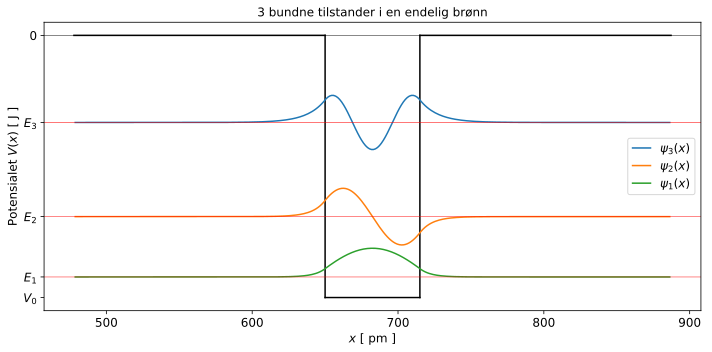

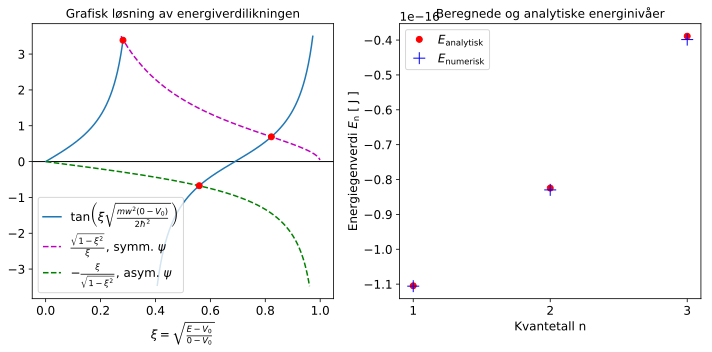

3 første kvantiserte energinivåene (numerisk):   [-1.106e-16 -8.296e-17 -3.986e-17] J
3 første kvantiserte energinivåene (analytisk):  [-1.105e-16 -8.244e-17 -3.888e-17] J
Relativt avvik i prosent:  [0.096 0.63  2.515]


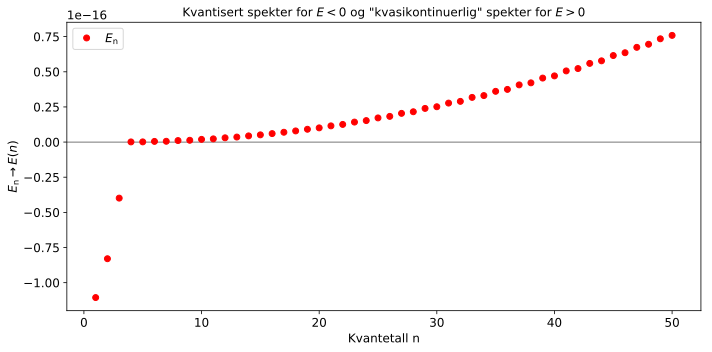

In [15]:
E, psi, x, L = eigenvalue_eigenvector(2) # Numerical solutions
plot3()
plot4()
plot5()

lambda_11(utenfor):  3.245e-10 m
lambda_11(innenfor): 4.500e-11 m

Kinetisk energi beregnet ved lambda_11:
K_utenfor:  2.288e-18 J
K_innenfor: 1.190e-16 J

Numerisk:
K_utenfor:  E_11 - 0  = 2.287e-18 J
K_innenfor: E_11 - V0 = 1.223e-16 J

Avvik:
Avvik på K_utenfor: 0.06 %
Avvik på K_innenfor: 2.68 %


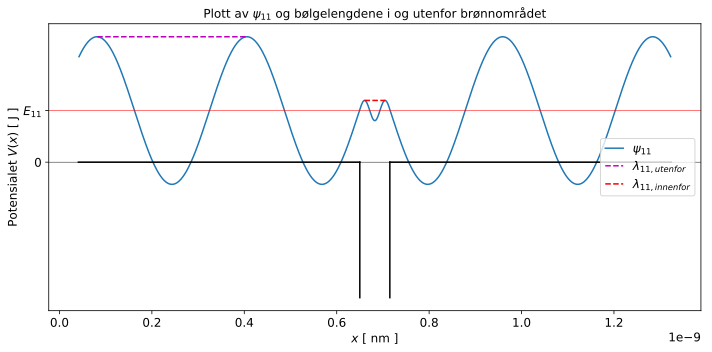

In [16]:
# Sjekker spesifikt bølgelengden til en psi_11
def finding_wavelength():
    idx = argrelextrema(psi[:,10], np.greater)[0]
    return idx

def plot6():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    index = finding_wavelength()
    
    N = x.size
    sl = 30 # slice
    plt.plot(x[sl:-sl], psi[sl:-sl,10]/1.2e22+E[10], label=r'$\psi_{11}$')
    plt.plot(x[index[:2]], psi[index[:2],10]/1.2e22+E[10], 'm--', label=r'$\lambda_{11, utenfor}$')
    plt.plot(x[index[2:4]], psi[index[2:4],10]/1.2e22+E[10], 'r--', label=r'$\lambda_{11, innenfor}$')
    
    
    
    plt.title(r"Plott av $\psi_{11}$ og bølgelengdene i og utenfor brønnområdet")
    plt.plot((L*sl/N, (L - w)/2), (0,0), 'k-')
    plt.plot(((L + w)/2, L*(1 - sl/N)), (0,0), 'k-')
    plt.plot(((L - w)/2, (L - w)/2), (V0/20,0), 'k-')
    plt.plot(((L + w)/2, (L + w)/2), (V0/20,0), 'k-')
    plt.axhline(0, linewidth=0.5, color='black')
    plt.axhline(E[10], linewidth=0.5, color='red')
    plt.xlabel(r'$x$ [ nm ]')
    plt.ylabel(r'Potensialet $V(x)$ [ J ]')
    #plt.xticks([2.0e-10, 4.0e-10, 6.0e-10, 8.0e-10, 10.0e-10, 12.0e-10], [0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    plt.yticks([0, E[10]],
              [0, r'$E_{11}$'])
    plt.legend(loc='right')
    
    plt.show()
    return

def kinetic_energy(lambd):
    return 2/m*((np.pi * hBar)/lambd)**2

def show_lambda_result():
    index = finding_wavelength()
    lambda_out = x[index[1]] - x[index[0]]
    lambda_in = x[index[3]] - x[index[2]]
    kin_o = kinetic_energy(lambda_out)
    kin_i = kinetic_energy(lambda_in)
    
    print("lambda_11(utenfor):  %.3e" % lambda_out, "m")
    print("lambda_11(innenfor): %.3e" % lambda_in, "m")
    print()
    print("Kinetisk energi beregnet ved lambda_11:")
    print("K_utenfor:  %.3e" % kin_o, "J")
    print("K_innenfor: %.3e" % kin_i, "J")
    print()
    print("Numerisk:")
    print("K_utenfor:  E_11 - 0  = %.3e" % E[10], "J")
    print("K_innenfor: E_11 - V0 = %.3e" % (E[10] - V0), "J")
    print()
    print("Avvik:")
    dev_o = 100*np.abs(E[10]-kin_o)/E[10]
    dev_i = 100*np.abs(E[10]-V0-kin_i)/(E[10]-V0)
    print("Avvik på K_utenfor: %.2f" % dev_o, "%")
    print("Avvik på K_innenfor: %.2f" % dev_i, "%")
show_lambda_result()
plot6()

## Oppgave 3

In [17]:
def exer_3(N):
    L = 2*w + 2*10*w + b
    DeltaX = L/(N+1) # Delta x
    x = np.linspace(0, L, N+2)
    c = -hBar**2/(2*m * DeltaX**2)
    d = -2*c * np.ones(N) # the diagonal elements of the array
    e = c * np.ones(N-1) # the off-diagonal elements of the array
    d[int(np.rint(N/L * ((L - b)/2 - w))) : int(np.rint(N/L * (L - b)/2))] += V0
    d[int(np.rint(N/L * (L + b)/2)) : int(np.rint(N/L * ((L + b)/2 + w)))] += V0
    return x[1:-1], DeltaX, L, d, e

Bindingsenergi til H_2: 17.02 eV
Bindingsenergi til He_2: 8.80 eV


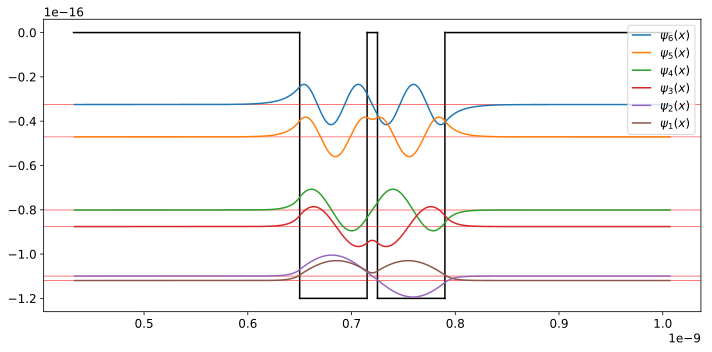

In [18]:
def plot7():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    sl = 300
    N = x.size
    plt.plot((sl/N*L,10*w), (0,0), color='black')
    plt.plot(((L-b)/2, (L+b)/2), (0,0), color='black')
    plt.plot((L-10*w,L*(1 - sl/N)), (0,0), color='black')
    plt.plot((10*w, (L-b)/2), (V0, V0), color='black')
    plt.plot(((L+b)/2, L-10*w),(V0, V0), color='black')
    plt.plot((10*w,10*w),(V0,0), color='black')
    plt.plot(((L-b)/2,(L-b)/2), (V0,0), color='black')
    plt.plot(((L+b)/2,(L+b)/2),(V0,0),color='black')
    plt.plot((L-10*w,L-10*w),(V0,0),color='black')
    plt.axhline(E[5], linewidth=0.5, color='red')
    plt.axhline(E[4], linewidth=0.5, color='red')
    plt.axhline(E[3], linewidth=0.5, color='red')
    plt.axhline(E[2], linewidth=0.5, color='red')
    plt.axhline(E[1], linewidth=0.5, color='red')
    plt.axhline(E[0], linewidth=0.5, color='red')
    plt.plot(x[sl:-sl], psi[sl:-sl,5]/1.2e22+E[5], label="$\psi_6(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,4]/1.2e22+E[4], label="$\psi_5(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,3]/1.2e22+E[3], label="$\psi_4(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,2]/1.2e22+E[2], label="$\psi_3(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,1]/1.2e22+E[1], label="$\psi_2(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,0]/1.2e22+E[0], label="$\psi_1(x)$")
    plt.legend(loc='best')
    
    plt.show()

E, psi, x, L = eigenvalue_eigenvector(3)
E_last, psi_last, x_last, L_last = eigenvalue_eigenvector(2)

ave_bond_enthalpy_hydrogen = (2*E_last[0] - 2*E[0])/e
ave_bond_enthalpy_helium = (2*2*E_last[0] - (2*E[0] + 2*E[1]))/e
print("Bindingsenergi til H_2: %.2f" % ave_bond_enthalpy_hydrogen, "eV")
print("Bindingsenergi til He_2: %.2f" % ave_bond_enthalpy_helium, "eV")
plot7()

## Oppgave 4

In [19]:
def exer_4(N, N_w):
    L = N_w*w + 2*10*w + (N_w - 1)*b
    DeltaX = L/(N+1) # Delta x
    x = np.linspace(0, L, N+2)
    c = -hBar**2/(2*m * DeltaX**2)
    d = -2*c * np.ones(N) # the diagonal elements of the array
    e = c * np.ones(N-1) # the off-diagonal elements of the array
    update_diagonal(d, N, N_w, L)
    return x[1:-1], DeltaX, L, d, e


    d[int(np.rint(N/L * ((L - b)/2 - w))) : int(np.rint(N/L * (L - b)/2))] += V0
    d[int(np.rint(N/L * (L + b)/2)) : int(np.rint(N/L * ((L + b)/2 + w)))] += V0

def update_diagonal(d, N, N_w, L):
    if N_w % 2 and N_w > 0:
        d[int(np.rint(N/L*(L-w)/2)):int(np.rint(N/L*(L+w)/2))] += V0
        for i in range(N_w//2):
            d[int(np.rint(N/L*((L+w)/2 + b + i*(w+b)))):int(np.rint(N/L*((L+w)/2 + b + i*(w+b) + w)))] += V0
            d[int(np.rint(N/L*((L-w)/2 - b - w - i*(w+b)))):int(np.rint(N/L*((L-w)/2 - b - i*(w+b))))] += V0
    elif N_w > 0:
        for i in range(N_w//2):
            d[int(np.rint(N/L * ((L+b)/2 + i*(w+b)))) : int(np.rint(N/L * ((L+b)/2 + i*(w+b) + w)))] += V0
            d[int(np.rint(N/L*((L-b)/2 - i*(w+b) - w))):int(np.rint(N/L*((L-b)/2 - i*(w+b))))] += V0

In [40]:
def plot8():
    sl = 1
    N = x.size
    
    plt.plot((L*sl/N,10*w),(0,0), linewidth=0.1, color='black')
    plt.plot((L*(1-sl/N),L-10*w),(0,0), linewidth=0.1, color='black')
    if Nw % 2:
        plt.plot(((L-w)/2,(L+w)/2), (V0,V0), linewidth=0.1, color='black')
        plt.plot(((L-w)/2,(L-w)/2),(V0,0), linewidth=0.1, color='black')
        plt.plot(((L+w)/2,(L+w)/2),(V0,0), linewidth=0.1, color='black')
        for i in range(Nw//2):
            plt.plot(((L+w)/2+i*(w+b), (L+w)/2+b+i*(w+b)),(0,0), linewidth=0.1, color='black')
            plt.plot(((L+w)/2+b+i*(w+b), (L+w)/2+b+i*(w+b)),(0,V0), linewidth=0.1, color='black')
            plt.plot(((L+w)/2+b+i*(w+b), (L+w)/2+b+w+i*(w+b)),(V0,V0), linewidth=0.1, color='black')
            plt.plot(((L+w)/2+b+w+i*(w+b), (L+w)/2+b+w+i*(w+b)),(V0,0), linewidth=0.1, color='black')
            
            plt.plot(((L-w)/2-i*(w+b), (L-w)/2-b-i*(w+b)),(0,0), linewidth=0.1, color='black')
            plt.plot(((L-w)/2-b-i*(w+b), (L-w)/2-b-i*(w+b)),(0,V0), linewidth=0.1, color='black')
            plt.plot(((L-w)/2-b-i*(w+b), (L-w)/2-b-w-i*(w+b)),(V0,V0), linewidth=0.1, color='black')
            plt.plot(((L-w)/2-b-w-i*(w+b), (L-w)/2-b-w-i*(w+b)),(V0,0), linewidth=0.1, color='black')
    elif Nw > 0:
        plt.plot(((L-b)/2,(L+b)/2), (0,0), linewidth=0.1, color='black')
        for i in range(Nw//2):
            plt.plot(((L+b)/2+i*(w+b),(L+b)/2+i*(w+b)), (V0,0), linewidth=0.1, color='black')
            plt.plot(((L-b)/2-i*(w+b),(L-b)/2-i*(w+b)), (V0,0), linewidth=0.1, color='black')
            plt.plot(((L+b)/2+w+i*(w+b),(L+b)/2+w+i*(w+b)), (V0,0), linewidth=0.1, color='black')
            plt.plot(((L-b)/2-w-i*(w+b),(L-b)/2-w-i*(w+b)), (V0,0), linewidth=0.1, color='black')
            
            plt.plot(((L+b)/2+i*(b+w),(L+b)/2+i*(b+w)+w),(V0,V0), linewidth=0.1, color='black')
            plt.plot(((L-b)/2-i*(b+w),(L-b)/2-i*(b+w)-w),(V0,V0), linewidth=0.1, color='black')
            if i != Nw//2-1:
                plt.plot(((L+b)/2+w+i*(b+w),(L+b)/2+w+i*(b+w)+b),(0,0), linewidth=0.1, color='black')
                plt.plot(((L-b)/2-w-i*(b+w),(L-b)/2-w-i*(b+w)-b),(0,0), linewidth=0.1, color='black')
    
    plt.plot(x[sl:-sl], psi[sl:-sl,11]/1e22 + E[11], label=r'$\psi_\mathrm{12}$')
    plt.plot(x[sl:-sl], psi[sl:-sl,10]/1e22 + E[10], label=r'$\psi_\mathrm{11}$')
    plt.plot(x[sl:-sl], psi[sl:-sl,9]/1e22 + E[9], label=r'$\psi_\mathrm{10}$')
    plt.plot(x[sl:-sl], psi[sl:-sl,8]/1e22 + E[8], label=r'$\psi_9$')
    plt.plot(x[sl:-sl], psi[sl:-sl,7]/1e22 + E[7], label=r'$\psi_8$')
    plt.plot(x[sl:-sl], psi[sl:-sl,6]/1e22 + E[6], label=r'$\psi_7$')
    plt.plot(x[sl:-sl], psi[sl:-sl,5]/1e22 + E[5], label=r'$\psi_6$')
    plt.plot(x[sl:-sl], psi[sl:-sl,4]/1e22 + E[4], label=r'$\psi_5$')
    plt.plot(x[sl:-sl], psi[sl:-sl,3]/1e22 + E[3], label=r'$\psi_4$')
    plt.plot(x[sl:-sl], psi[sl:-sl,2]/1e22 + E[2], label=r'$\psi_3$')
    plt.plot(x[sl:-sl], psi[sl:-sl,1]/1e22 + E[1], label=r'$\psi_2$')
    plt.plot(x[sl:-sl], psi[sl:-sl,0]/1e22 + E[0], label=r'$\psi_1$')
    
    plt.legend(loc='best')
    plt.show()

def plot9():
    N = x.size
    Nw_arr = 2 + np.arange(99)
    n = Nw_arr.size
    E_1 = np.zeros(n)
    E_2 = np.zeros(n)
    E_3 = np.zeros(n)
    for i in range(n):
        E, _1, _2, _3 = eigenvalue_eigenvector(4, Nw_arr[i])
        E_1[i] = E[Nw_arr[i]-1] - E[0]
        E_2[i] = E[2*(Nw_arr[i])-1] - E[Nw_arr[i]]
        E_3[i] = E[3*(Nw_arr[i])-1] - E[2*Nw_arr[i]]
    plt.plot(Nw_arr, E_3, 'm.', markersize=2, label=r'$E_\mathrm{3N_w} - E_{\mathrm{2N_w}+1}$')
    plt.plot(Nw_arr, E_2, 'b.', markersize=2, label=r'$E_\mathrm{2N_w} - E_{\mathrm{N_w}+1}$')
    plt.plot(Nw_arr, E_1, 'r.', markersize=2, label=r'$E_\mathrm{N_w} - E_1$')
    plt.legend(loc='upper left')

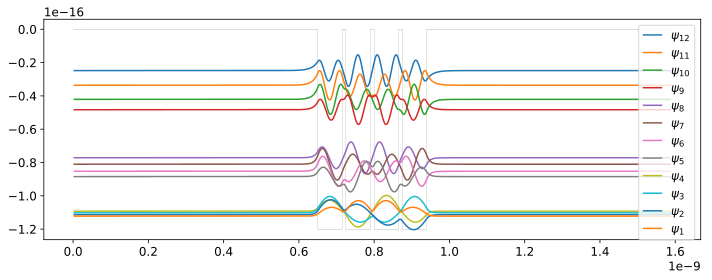

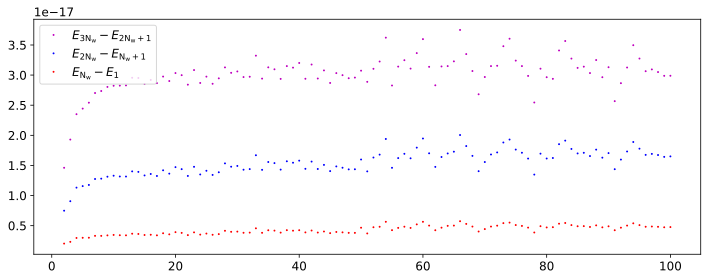

In [41]:
Nw = 4
E, psi, x, L = eigenvalue_eigenvector(4,Nw)

plot8()
plot9()